# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=75,
        fold=2,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_18-36-07/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5276 | MulticlassF1Score=0.0357
Batch-30 : CrossEntropyLoss=2.4844 | MulticlassF1Score=0.1319
Batch-45 : CrossEntropyLoss=2.4824 | MulticlassF1Score=0.1739
Batch-60 : CrossEntropyLoss=2.5119 | MulticlassF1Score=0.1959
Batch-75 : CrossEntropyLoss=2.4806 | MulticlassF1Score=0.2099
Batch-90 : CrossEntropyLoss=2.4528 | MulticlassF1Score=0.2245
Batch-105: CrossEntropyLoss=2.4346 | MulticlassF1Score=0.2433
Batch-120: CrossEntropyLoss=2.4311 | MulticlassF1Score=0.2593
Batch-135: CrossEntropyLoss=2.4381 | MulticlassF1Score=0.2717
Batch-150: CrossEntropyLoss=2.4262 | MulticlassF1Score=0.2815
Batch-165: CrossEntropyLoss=2.4162 | MulticlassF1Score=0.2929
Batch-180: CrossEntropyLoss=2.3728 | MulticlassF1Score=0.3120
Batch-195: CrossEntropyLoss=2.3884 | MulticlassF1Score=0.3324
Batch-210: CrossEntropyLoss=2.3661 | MulticlassF1Score=0.3508
Batch-225: CrossEntropyLoss=2.3748 | MulticlassF1Score=0.3661
Batch-226: CrossEntropyLoss=2.3784 | MulticlassF1Score=0.3665

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3730 | MulticlassF1Score=0.5964
Batch-30 : CrossEntropyLoss=2.3749 | MulticlassF1Score=0.5948
Batch-45 : CrossEntropyLoss=2.3844 | MulticlassF1Score=0.5955
Batch-60 : CrossEntropyLoss=2.3766 | MulticlassF1Score=0.5951
Batch-63 : CrossEntropyLoss=2.3568 | MulticlassF1Score=0.5941

Training   : Mean CrossEntropyLoss = 2.4534 | Mean MulticlassF1Score = 0.2366
Validation : Mean CrossEntropyLoss = 2.3740 | Mean MulticlassF1Score = 0.5946

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3561 | MulticlassF1Score=0.5951
Batch-30 : CrossEntropyLoss=2.3719 | MulticlassF1Score=0.5933
Batch-45 : CrossEntropyLoss=2.3482 | MulticlassF1Score=0.6174
Batch-60 : CrossEntropyLoss=2.3431 | MulticlassF1Score=0.6286
Batch-75 : CrossEntropyLoss=2.3281 | MulticlassF1Score=0.6419
Batch-90 : CrossEntropyLoss=2.3451 | MulticlassF1Score=0.6550
Batch-105: CrossEntropyLoss=2.3309 | MulticlassF1Score=0.6637
Batch-120: CrossEntropyLoss=2.3433 | MulticlassF1Score=0.6702
Batch-135: CrossEntropyLoss=2.3266 | MulticlassF1Score=0.6777
Batch-150: CrossEntropyLoss=2.3263 | MulticlassF1Score=0.6855
Batch-165: CrossEntropyLoss=2.3047 | MulticlassF1Score=0.6944
Batch-180: CrossEntropyLoss=2.3122 | MulticlassF1Score=0.7022
Batch-195: CrossEntropyLoss=2.3173 | MulticlassF1Score=0.7083
Batch-210: CrossEntropyLoss=2.3086 | MulticlassF1Score=0.7138
Batch-225: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.7190
Batch-226: CrossEntropyLoss=2.3071 | MulticlassF1Score=0.7192

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3155 | MulticlassF1Score=0.7873
Batch-30 : CrossEntropyLoss=2.3150 | MulticlassF1Score=0.7880
Batch-45 : CrossEntropyLoss=2.3075 | MulticlassF1Score=0.7884
Batch-60 : CrossEntropyLoss=2.3249 | MulticlassF1Score=0.7901
Batch-63 : CrossEntropyLoss=2.3107 | MulticlassF1Score=0.7895

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3361 | Mean MulticlassF1Score = 0.6616
Validation : Mean CrossEntropyLoss = 2.3135 | Mean MulticlassF1Score = 0.7888

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3119 | MulticlassF1Score=0.7912
Batch-30 : CrossEntropyLoss=2.3102 | MulticlassF1Score=0.7916
Batch-45 : CrossEntropyLoss=2.3111 | MulticlassF1Score=0.7910
Batch-60 : CrossEntropyLoss=2.3097 | MulticlassF1Score=0.7896
Batch-75 : CrossEntropyLoss=2.3185 | MulticlassF1Score=0.7897
Batch-90 : CrossEntropyLoss=2.3125 | MulticlassF1Score=0.7922
Batch-105: CrossEntropyLoss=2.3154 | MulticlassF1Score=0.7920
Batch-120: CrossEntropyLoss=2.3169 | MulticlassF1Score=0.7927
Batch-135: CrossEntropyLoss=2.3117 | MulticlassF1Score=0.7924
Batch-150: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.7924
Batch-165: CrossEntropyLoss=2.3127 | MulticlassF1Score=0.7921
Batch-180: CrossEntropyLoss=2.3126 | MulticlassF1Score=0.7920
Batch-195: CrossEntropyLoss=2.3190 | MulticlassF1Score=0.7928
Batch-210: CrossEntropyLoss=2.3172 | MulticlassF1Score=0.7928
Batch-225: CrossEntropyLoss=2.3082 | MulticlassF1Score=0.7930
Batch-226: CrossEntropyLoss=2.3185 | MulticlassF1Score=0.7929

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3175 | MulticlassF1Score=0.7975
Batch-30 : CrossEntropyLoss=2.3117 | MulticlassF1Score=0.7932
Batch-45 : CrossEntropyLoss=2.3117 | MulticlassF1Score=0.7968
Batch-60 : CrossEntropyLoss=2.3118 | MulticlassF1Score=0.7942
Batch-63 : CrossEntropyLoss=2.3171 | MulticlassF1Score=0.7934

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3123 | Mean MulticlassF1Score = 0.7916
Validation : Mean CrossEntropyLoss = 2.3117 | Mean MulticlassF1Score = 0.7942

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3032 | MulticlassF1Score=0.7974
Batch-30 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.7996
Batch-45 : CrossEntropyLoss=2.3148 | MulticlassF1Score=0.7977
Batch-60 : CrossEntropyLoss=2.3063 | MulticlassF1Score=0.7975
Batch-75 : CrossEntropyLoss=2.3190 | MulticlassF1Score=0.7968
Batch-90 : CrossEntropyLoss=2.3138 | MulticlassF1Score=0.7966
Batch-105: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.7976
Batch-120: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.7999
Batch-135: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8019
Batch-150: CrossEntropyLoss=2.3097 | MulticlassF1Score=0.8047
Batch-165: CrossEntropyLoss=2.3198 | MulticlassF1Score=0.8063
Batch-180: CrossEntropyLoss=2.3082 | MulticlassF1Score=0.8083
Batch-195: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8094
Batch-210: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8103
Batch-225: CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8114
Batch-226: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8115

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8258
Batch-30 : CrossEntropyLoss=2.3066 | MulticlassF1Score=0.8273
Batch-45 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8249
Batch-60 : CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8248
Batch-63 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8253

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3063 | Mean MulticlassF1Score = 0.8020
Validation : Mean CrossEntropyLoss = 2.3018 | Mean MulticlassF1Score = 0.8247

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8229
Batch-30 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8262
Batch-45 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8265
Batch-60 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8265
Batch-75 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8259
Batch-90 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8262
Batch-105: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8283
Batch-120: CrossEntropyLoss=2.3081 | MulticlassF1Score=0.8290
Batch-135: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8295
Batch-150: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8298
Batch-165: CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8289
Batch-180: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8285
Batch-195: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8284
Batch-210: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8287
Batch-225: CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8289
Batch-226: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8289

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3138 | MulticlassF1Score=0.8233
Batch-30 : CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8250
Batch-45 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8257
Batch-60 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8273
Batch-63 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8272

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3007 | Mean MulticlassF1Score = 0.8281
Validation : Mean CrossEntropyLoss = 2.3011 | Mean MulticlassF1Score = 0.8258

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3148 | MulticlassF1Score=0.8257
Batch-30 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8276
Batch-45 : CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8318
Batch-60 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8318
Batch-75 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8315
Batch-90 : CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8310
Batch-105: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8312
Batch-120: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8298
Batch-135: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8307
Batch-150: CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8295
Batch-165: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8307
Batch-180: CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8302
Batch-195: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8302
Batch-210: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8305
Batch-225: CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8309
Batch-226: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8310

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3100 | MulticlassF1Score=0.8239
Batch-30 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8273
Batch-45 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8270
Batch-60 : CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8275
Batch-63 : CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8278

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3000 | Mean MulticlassF1Score = 0.8301
Validation : Mean CrossEntropyLoss = 2.3009 | Mean MulticlassF1Score = 0.8265

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8341
Batch-30 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8306
Batch-45 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8323
Batch-60 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8369
Batch-75 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8402
Batch-90 : CrossEntropyLoss=2.3099 | MulticlassF1Score=0.8418
Batch-105: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8422
Batch-120: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8423
Batch-135: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8439
Batch-150: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8455
Batch-165: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8465
Batch-180: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8467
Batch-195: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8471
Batch-210: CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8472
Batch-225: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8481
Batch-226: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8482

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8479
Batch-30 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8500
Batch-45 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8526
Batch-60 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8521
Batch-63 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8524

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2950 | Mean MulticlassF1Score = 0.8414
Validation : Mean CrossEntropyLoss = 2.2935 | Mean MulticlassF1Score = 0.8498

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8568
Batch-30 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8573
Batch-45 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8577
Batch-60 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8565
Batch-75 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8576
Batch-90 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8611
Batch-105: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8644
Batch-120: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8671
Batch-135: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8688
Batch-150: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8713
Batch-165: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8725
Batch-180: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8737
Batch-195: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8744
Batch-210: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8750
Batch-225: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8758
Batch-226: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8759

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8792
Batch-30 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8823
Batch-45 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8817
Batch-60 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8808
Batch-63 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8809

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2865 | Mean MulticlassF1Score = 0.8657
Validation : Mean CrossEntropyLoss = 2.2848 | Mean MulticlassF1Score = 0.8820

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8865
Batch-30 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8863
Batch-45 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8883
Batch-60 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8884
Batch-75 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8878
Batch-90 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8880
Batch-105: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8878
Batch-120: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8882
Batch-135: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8876
Batch-150: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8877
Batch-165: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8879
Batch-180: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8881
Batch-195: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8882
Batch-210: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8886
Batch-225: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8885
Batch-226: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8885

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8829
Batch-30 : CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8848
Batch-45 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8826
Batch-60 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8827
Batch-63 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8828

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2825 | Mean MulticlassF1Score = 0.8878
Validation : Mean CrossEntropyLoss = 2.2841 | Mean MulticlassF1Score = 0.8825

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8923
Batch-30 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8926
Batch-45 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8924
Batch-60 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8909
Batch-75 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8906
Batch-90 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8907
Batch-105: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8907
Batch-120: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8906
Batch-135: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8907
Batch-150: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8910
Batch-165: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8908
Batch-180: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8908
Batch-195: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8910
Batch-210: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.8910
Batch-225: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8910
Batch-226: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.8910

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8837
Batch-30 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8857
Batch-45 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8857
Batch-60 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8848
Batch-63 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8844

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8913
Validation : Mean CrossEntropyLoss = 2.2837 | Mean MulticlassF1Score = 0.8853

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8977
Batch-30 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8949
Batch-45 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8948
Batch-60 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8935
Batch-75 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8927
Batch-90 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8923
Batch-105: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8926
Batch-120: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8926
Batch-135: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8928
Batch-150: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8923
Batch-165: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8928
Batch-180: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8926
Batch-195: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8930
Batch-210: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8932
Batch-225: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8932
Batch-226: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8932

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8824
Batch-30 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8836
Batch-45 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8834
Batch-60 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8836
Batch-63 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8838

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2808 | Mean MulticlassF1Score = 0.8936
Validation : Mean CrossEntropyLoss = 2.2835 | Mean MulticlassF1Score = 0.8828

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8991
Batch-30 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8942
Batch-45 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8944
Batch-60 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8942
Batch-75 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8949
Batch-90 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8953
Batch-105: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8954
Batch-120: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8950
Batch-135: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8952
Batch-150: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8951
Batch-165: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8951
Batch-180: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8952
Batch-195: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8951
Batch-210: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8949
Batch-225: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8948
Batch-226: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.8949

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8885
Batch-30 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8851
Batch-45 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8854
Batch-60 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8853
Batch-63 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8851

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2802 | Mean MulticlassF1Score = 0.8957
Validation : Mean CrossEntropyLoss = 2.2832 | Mean MulticlassF1Score = 0.8865

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8985
Batch-30 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8974
Batch-45 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.8973
Batch-60 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8967
Batch-75 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8965
Batch-90 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8962
Batch-105: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8963
Batch-120: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8967
Batch-135: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8961
Batch-150: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8966
Batch-165: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8965
Batch-180: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8960
Batch-195: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8963
Batch-210: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8963
Batch-225: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.8961
Batch-226: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8961

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8830
Batch-30 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8845
Batch-45 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8855
Batch-60 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8858
Batch-63 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8862

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2798 | Mean MulticlassF1Score = 0.8967
Validation : Mean CrossEntropyLoss = 2.2828 | Mean MulticlassF1Score = 0.8847

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8993
Batch-30 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9019
Batch-45 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9017
Batch-60 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9006
Batch-75 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9005
Batch-90 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9002
Batch-105: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9005
Batch-120: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9005
Batch-135: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.9003
Batch-150: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.9004
Batch-165: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9013
Batch-180: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9034
Batch-195: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9048
Batch-210: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9063
Batch-225: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9073
Batch-226: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9073

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9144
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9145
Batch-45 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.9151
Batch-60 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9140
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9142

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2764 | Mean MulticlassF1Score = 0.9018
Validation : Mean CrossEntropyLoss = 2.2744 | Mean MulticlassF1Score = 0.9135

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9254
Batch-30 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9258
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9267
Batch-60 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9260
Batch-75 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9270
Batch-90 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9269
Batch-105: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9268
Batch-120: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9277
Batch-135: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9282
Batch-150: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9283
Batch-165: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9286
Batch-180: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9289
Batch-195: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9290
Batch-210: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9289
Batch-225: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9290
Batch-226: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9289

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9198
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9188
Batch-45 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9192
Batch-60 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9190
Batch-63 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9190

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9277
Validation : Mean CrossEntropyLoss = 2.2730 | Mean MulticlassF1Score = 0.9204

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9308
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9305
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9313
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9315
Batch-75 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9313
Batch-90 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9315
Batch-105: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9321
Batch-120: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9317
Batch-135: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9318
Batch-150: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9318
Batch-165: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9318
Batch-180: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9317
Batch-195: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9318
Batch-210: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9321
Batch-225: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9321
Batch-226: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9321

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9189
Batch-30 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9183
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9185
Batch-60 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9186
Batch-63 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9187

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2688 | Mean MulticlassF1Score = 0.9316
Validation : Mean CrossEntropyLoss = 2.2728 | Mean MulticlassF1Score = 0.9195

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9301
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9301
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9311
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9325
Batch-75 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9329
Batch-90 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9328
Batch-105: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9326
Batch-120: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9327
Batch-135: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9331
Batch-150: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9328
Batch-165: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9331
Batch-180: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9332
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9332
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9334
Batch-225: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9334
Batch-226: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9333

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9203
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9190
Batch-45 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9192
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9193
Batch-63 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9192

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2683 | Mean MulticlassF1Score = 0.9323
Validation : Mean CrossEntropyLoss = 2.2727 | Mean MulticlassF1Score = 0.9195

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9338
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9351
Batch-45 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9351
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9344
Batch-75 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9351
Batch-90 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9349
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9350
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9351
Batch-135: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9351
Batch-150: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9347
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9347
Batch-180: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9347
Batch-195: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9349
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9345
Batch-225: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9344
Batch-226: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9344

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9242
Batch-30 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9217
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9199
Batch-60 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9191
Batch-63 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9194

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2680 | Mean MulticlassF1Score = 0.9347
Validation : Mean CrossEntropyLoss = 2.2727 | Mean MulticlassF1Score = 0.9216

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9347
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9369
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9369
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9369
Batch-75 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9367
Batch-90 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9362
Batch-105: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9357
Batch-120: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9361
Batch-135: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9357
Batch-150: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9357
Batch-165: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9359
Batch-180: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9356
Batch-195: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9357
Batch-210: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9356
Batch-225: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9357
Batch-226: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9357

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9197
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9188
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9203
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9192
Batch-63 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9198

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2675 | Mean MulticlassF1Score = 0.9357
Validation : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9200

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9349
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9367
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9372
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9372
Batch-75 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9371
Batch-90 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9371
Batch-105: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9371
Batch-120: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9369
Batch-135: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9369
Batch-150: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9367
Batch-165: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9366
Batch-180: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9369
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9367
Batch-210: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9367
Batch-225: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9364
Batch-226: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9364

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9228
Batch-30 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9198
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9199
Batch-60 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9203
Batch-63 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9206

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9367
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9210

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9388
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9368
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9367
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9364
Batch-75 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9366
Batch-90 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9366
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9372
Batch-120: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9368
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9369
Batch-150: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9372
Batch-165: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9371
Batch-180: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9370
Batch-195: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9370
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9373
Batch-225: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9373
Batch-226: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9373

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9199
Batch-30 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9199
Batch-45 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9215
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9202
Batch-63 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9202

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9373
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9211

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9400
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9369
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9377
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9369
Batch-75 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9374
Batch-90 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9376
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9376
Batch-120: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9373
Batch-135: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9374
Batch-150: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9376
Batch-165: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9379
Batch-180: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9380
Batch-195: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9378
Batch-210: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9377
Batch-225: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9375
Batch-226: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9375

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9219
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9209
Batch-45 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9202
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9202
Batch-63 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9201

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9377
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9214

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9389
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9400
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9393
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9393
Batch-75 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9386
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9383
Batch-105: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9384
Batch-120: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9382
Batch-135: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9383
Batch-150: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9381
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9380
Batch-180: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9379
Batch-195: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9381
Batch-210: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9385
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9387
Batch-226: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9387

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9228
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9232
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9222
Batch-60 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9221
Batch-63 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9217

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9385
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9219

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9409
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9397
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9389
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9404
Batch-75 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9404
Batch-90 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9400
Batch-105: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9402
Batch-120: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9403
Batch-135: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9404
Batch-150: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9405
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9404
Batch-180: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9403
Batch-195: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9402
Batch-210: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9399
Batch-225: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9397
Batch-226: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9397

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9239
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9224
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9221
Batch-63 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9224

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9401
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9228

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9418
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9406
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9400
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9397
Batch-75 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9400
Batch-90 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9407
Batch-105: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9413
Batch-120: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9408
Batch-135: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9410
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9413
Batch-165: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9405
Batch-180: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9406
Batch-195: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9405
Batch-210: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9406
Batch-225: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9406
Batch-226: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9406

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9221
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9234
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9229
Batch-60 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9229
Batch-63 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9229

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9406
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9220

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9442
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9434
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9426
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9427
Batch-75 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9434
Batch-90 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9426
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9424
Batch-120: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9420
Batch-135: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9416
Batch-150: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9418
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9417
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9417
Batch-195: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9415
Batch-210: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9413
Batch-225: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9412
Batch-226: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9412

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9221
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9217
Batch-45 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9222
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9230
Batch-63 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9229

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9423
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9223

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9407
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9405
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9408
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9397
Batch-75 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9404
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9413
Batch-105: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9415
Batch-120: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9413
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9417
Batch-150: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9418
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9415
Batch-180: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9415
Batch-195: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9417
Batch-210: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9414
Batch-225: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9417
Batch-226: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9417

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9212
Batch-30 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9217
Batch-45 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9216
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9219
Batch-63 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9220

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9411
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9214

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9436
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9440
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9426
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9427
Batch-75 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9435
Batch-90 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9424
Batch-105: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9420
Batch-120: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9416
Batch-135: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9424
Batch-150: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9426
Batch-165: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9425
Batch-180: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9428
Batch-195: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9427
Batch-210: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9424
Batch-225: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9424
Batch-226: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9424

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9212
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9210
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9217
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9230
Batch-63 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9230

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9429
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9211

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9409
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9411
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9421
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9430
Batch-75 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9432
Batch-90 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9430
Batch-105: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9430
Batch-120: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9432
Batch-135: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9432
Batch-150: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9434
Batch-165: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9431
Batch-180: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9430
Batch-195: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9430
Batch-210: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9428
Batch-225: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9428
Batch-226: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9427

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9248
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9240
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9236
Batch-60 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9233
Batch-63 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9234

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9427
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9231

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9417
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9419
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9417
Batch-60 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9426
Batch-75 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9420
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9426
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9427
Batch-120: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9427
Batch-135: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9428
Batch-150: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9428
Batch-165: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9428
Batch-180: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9429
Batch-195: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9429
Batch-210: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9430
Batch-225: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9429
Batch-226: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9429

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9257
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9233
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9222
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9224

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9425
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9247

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9435
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9427
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9442
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9439
Batch-75 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9438
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9435
Batch-105: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9440
Batch-120: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9434
Batch-135: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9435
Batch-150: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9434
Batch-165: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9432
Batch-180: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9435
Batch-195: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9432
Batch-210: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9432
Batch-225: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9432
Batch-226: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9431

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9214
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9198
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9217
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9226
Batch-63 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9227

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9433
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9220

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9425
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9432
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9439
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9440
Batch-75 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9433
Batch-90 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9437
Batch-105: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9437
Batch-120: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9440
Batch-135: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9438
Batch-150: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9434
Batch-165: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9433
Batch-180: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9427
Batch-195: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9428
Batch-210: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9428
Batch-225: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9428
Batch-226: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9428

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9235
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9217
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9218
Batch-60 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9226
Batch-63 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9226

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9432
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9229
Patience = 1/50❗

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9470
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9434
Batch-75 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9433
Batch-90 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9430
Batch-105: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9430
Batch-120: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9429
Batch-135: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9426
Batch-150: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9423
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9426
Batch-180: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9427
Batch-195: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9426
Batch-210: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9430
Batch-225: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9429
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9429

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9206
Batch-30 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9207
Batch-45 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9225
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9233
Batch-63 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9231

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9435
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9221

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9399
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9427
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9435
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9440
Batch-75 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9441
Batch-90 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9433
Batch-105: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9437
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9437
Batch-135: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9438
Batch-150: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9436
Batch-165: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9433
Batch-180: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9433
Batch-195: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9432
Batch-210: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9434
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9431
Batch-226: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9431

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9208
Batch-30 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9226
Batch-45 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9208
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9215
Batch-63 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9219

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9434
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9211

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9457
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9443
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9433
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9427
Batch-75 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9427
Batch-90 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9431
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9442
Batch-120: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9461
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9475
Batch-150: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9487
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9499
Batch-180: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9511
Batch-195: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9525
Batch-210: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9530
Batch-225: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9537
Batch-226: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9537

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9429
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9426
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9407
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9423
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9418

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2618 | Mean MulticlassF1Score = 0.9473
Validation : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9412

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9627
Batch-30 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9630
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9632
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9635
Batch-75 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9631
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9635
Batch-105: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9634
Batch-120: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9633
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9632
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9630
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9629
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9630
Batch-195: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9628
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9630
Batch-225: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9632
Batch-226: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9632

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9395
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9428
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9417
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9417
Batch-63 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9420

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2589 | Mean MulticlassF1Score = 0.9633
Validation : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9410

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9650
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9640
Batch-45 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9647
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9641
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9648
Batch-90 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9642
Batch-105: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9641
Batch-120: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9642
Batch-135: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9642
Batch-150: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9639
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9640
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9641
Batch-195: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9638
Batch-210: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9636
Batch-225: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9634
Batch-226: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9635

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9426
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9420
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9440
Batch-60 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9428
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9428

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2587 | Mean MulticlassF1Score = 0.9643
Validation : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9429

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9653
Batch-30 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9658
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9658
Batch-60 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9654
Batch-75 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9652
Batch-90 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9646
Batch-105: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9645
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9647
Batch-135: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9646
Batch-150: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9645
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9642
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9643
Batch-195: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9640
Batch-210: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9640
Batch-225: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9639
Batch-226: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9639

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9403
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9415
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9417
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9418
Batch-63 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9421

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9647
Validation : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9412

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9638
Batch-30 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9658
Batch-45 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9646
Batch-60 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9647
Batch-75 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9641
Batch-90 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9638
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9639
Batch-120: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9641
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9639
Batch-150: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9638
Batch-165: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9643
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9643
Batch-195: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9643
Batch-210: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9645
Batch-225: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9644
Batch-226: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9644

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9428
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9441
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9425
Batch-60 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9427
Batch-63 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9426

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9644
Validation : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9426

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9637
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9645
Batch-45 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9646
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9649
Batch-75 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9645
Batch-90 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9649
Batch-105: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9647
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9645
Batch-135: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9650
Batch-150: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9650
Batch-165: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9649
Batch-180: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9648
Batch-195: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9646
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9645
Batch-225: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9645
Batch-226: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9645

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9383
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9398
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9418
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9423
Batch-63 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9427

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9644
Validation : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9401

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9677
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9652
Batch-45 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9643
Batch-60 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9643
Batch-75 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9646
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9644
Batch-105: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9646
Batch-120: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9647
Batch-135: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9650
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9648
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9646
Batch-180: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9647
Batch-195: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9645
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9644
Batch-225: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9647
Batch-226: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9646

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9399
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9397
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9405
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9424
Batch-63 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9425

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9650
Validation : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9404

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9643
Batch-30 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9649
Batch-45 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9664
Batch-60 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9661
Batch-75 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9663
Batch-90 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9660
Batch-105: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9659
Batch-120: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9661
Batch-135: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9659
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9656
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9654
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9651
Batch-195: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9647
Batch-210: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9646
Batch-225: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9646
Batch-226: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9646

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9431
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9419
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9420
Batch-63 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9415

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9652
Validation : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9430
Patience = 2/50❗

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9662
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9657
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9656
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9656
Batch-75 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9654
Batch-90 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9652
Batch-105: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9652
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9650
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9650
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9650
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9647
Batch-180: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9642
Batch-195: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9643
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9643
Batch-225: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9643
Batch-226: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9643

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9376
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9376
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9402
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9411
Batch-63 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9411

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2585 | Mean MulticlassF1Score = 0.9653
Validation : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9389
Patience = 3/50❗

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9640
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9638
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9644
Batch-60 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9638
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9645
Batch-90 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9643
Batch-105: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9644
Batch-120: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9642
Batch-135: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9640
Batch-150: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9642
Batch-165: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9642
Batch-180: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9639
Batch-195: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9640
Batch-210: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9638
Batch-225: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9638
Batch-226: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9638

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9456
Batch-30 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9425
Batch-45 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9413
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9414
Batch-63 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9417

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2587 | Mean MulticlassF1Score = 0.9641
Validation : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9434
Patience = 4/50❗

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9653
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9662
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9663
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9655
Batch-75 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9657
Batch-90 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9657
Batch-105: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9653
Batch-120: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9654
Batch-135: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9648
Batch-150: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9644
Batch-165: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9642
Batch-180: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9640
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9640
Batch-210: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9640
Batch-225: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9640
Batch-226: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9641

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9458
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9447
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9444

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2585 | Mean MulticlassF1Score = 0.9649
Validation : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9468

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9662
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9643
Batch-45 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9658
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9665
Batch-75 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9672
Batch-90 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9675
Batch-105: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9671
Batch-135: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9667
Batch-150: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9664
Batch-165: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9665
Batch-180: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9662
Batch-195: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9660
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9657
Batch-225: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9656
Batch-226: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9656

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9439
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9441
Batch-45 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9440
Batch-63 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9436

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9665
Validation : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9451

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9607
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9625
Batch-45 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9626
Batch-60 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9633
Batch-75 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9634
Batch-90 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9642
Batch-105: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9639
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9640
Batch-135: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9639
Batch-150: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9639
Batch-165: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9640
Batch-180: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9642
Batch-195: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9644
Batch-210: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9643
Batch-225: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9644
Batch-226: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9643

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9447
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9459
Batch-63 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9456

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9635
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9459
Patience = 5/50❗

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9665
Batch-30 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9670
Batch-45 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9672
Batch-60 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9667
Batch-75 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9665
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9666
Batch-105: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9665
Batch-120: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9664
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9665
Batch-150: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9666
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9666
Batch-180: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9666
Batch-195: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9668
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9669
Batch-225: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9670
Batch-226: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9670

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9452
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9455
Batch-63 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9459

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9667
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9470

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9645
Batch-30 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9659
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9661
Batch-60 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9665
Batch-75 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9666
Batch-90 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9672
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9672
Batch-120: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9675
Batch-135: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9675
Batch-150: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9674
Batch-180: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9676
Batch-195: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9680
Batch-210: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9680
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9681
Batch-226: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9681

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9462
Batch-63 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9463

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9667
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9467

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9705
Batch-30 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9694
Batch-45 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9689
Batch-60 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9688
Batch-75 : CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9689
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9691
Batch-120: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9690
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9691
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9692
Batch-180: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9692
Batch-195: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9692
Batch-210: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9689
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9689

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9457
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9441
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9457
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9466
Batch-63 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9465

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9692
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9452

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2570
Best CrossEntropyLoss training    : 2.2640
Best MulticlassF1Score validation : 0.9692
Best MulticlassF1Score validation : 0.9452
Training duration                 : 2.0220 minutes.
Training date                     : 2022-10-19 13:03:53.900740+08:00


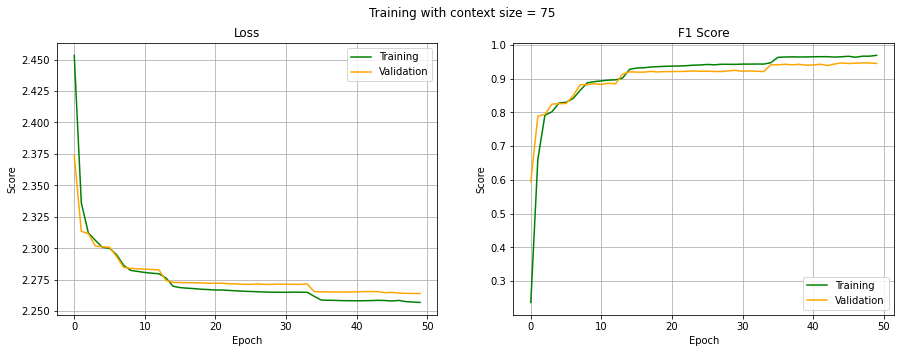

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9693, device='cuda:0'),
 tensor(0.9465, device='cuda:0'),
 tensor(0.9475, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9693, device='cuda:0'),
 tensor(0.9465, device='cuda:0'),
 tensor(0.9475, device='cuda:0'))

## Heatmap

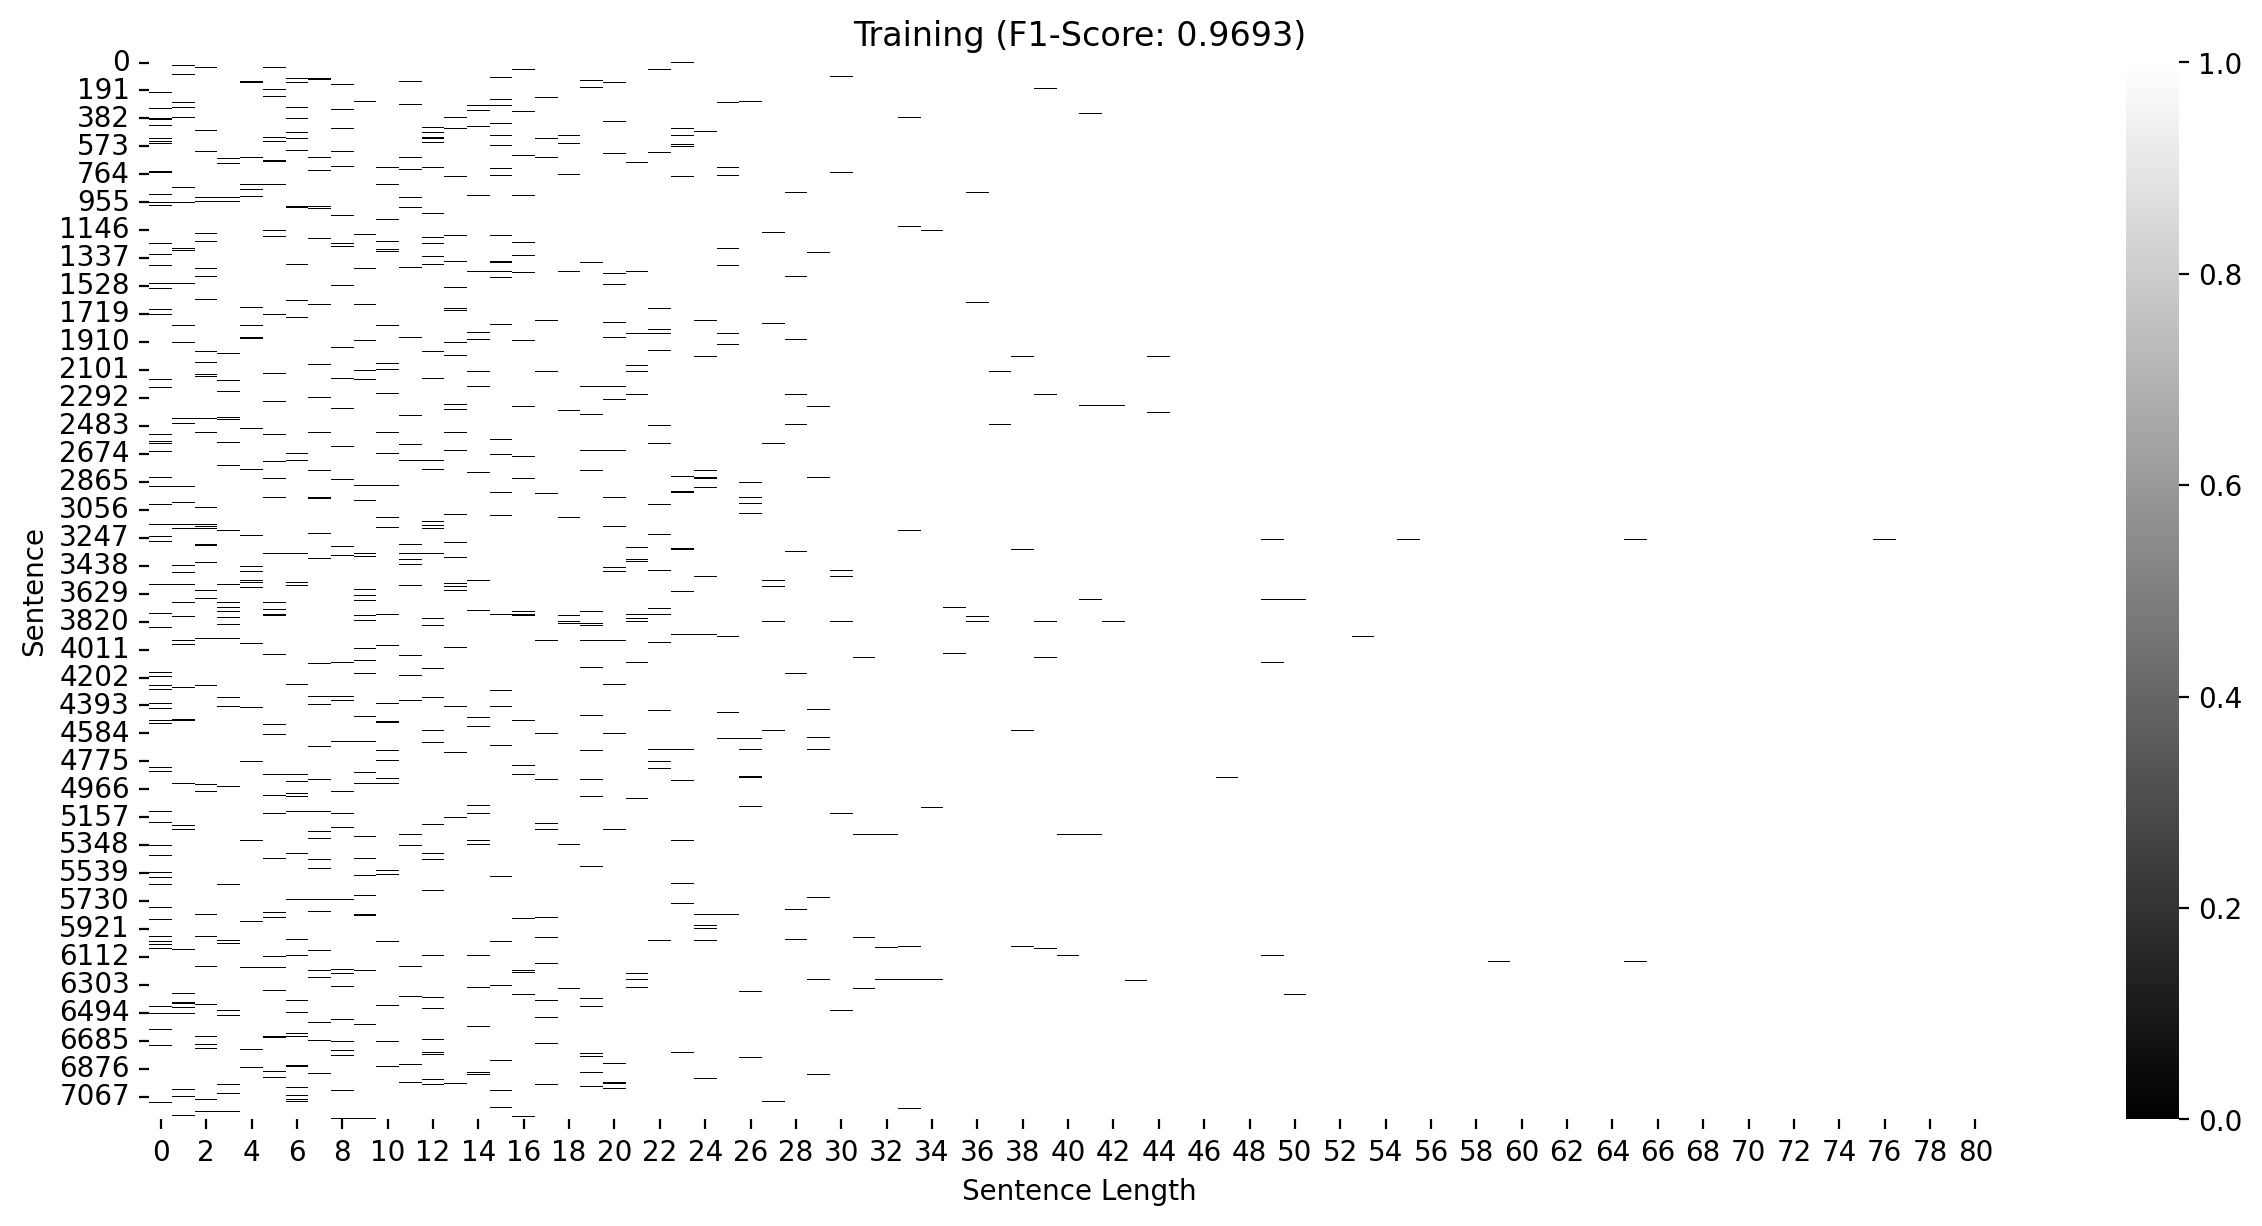

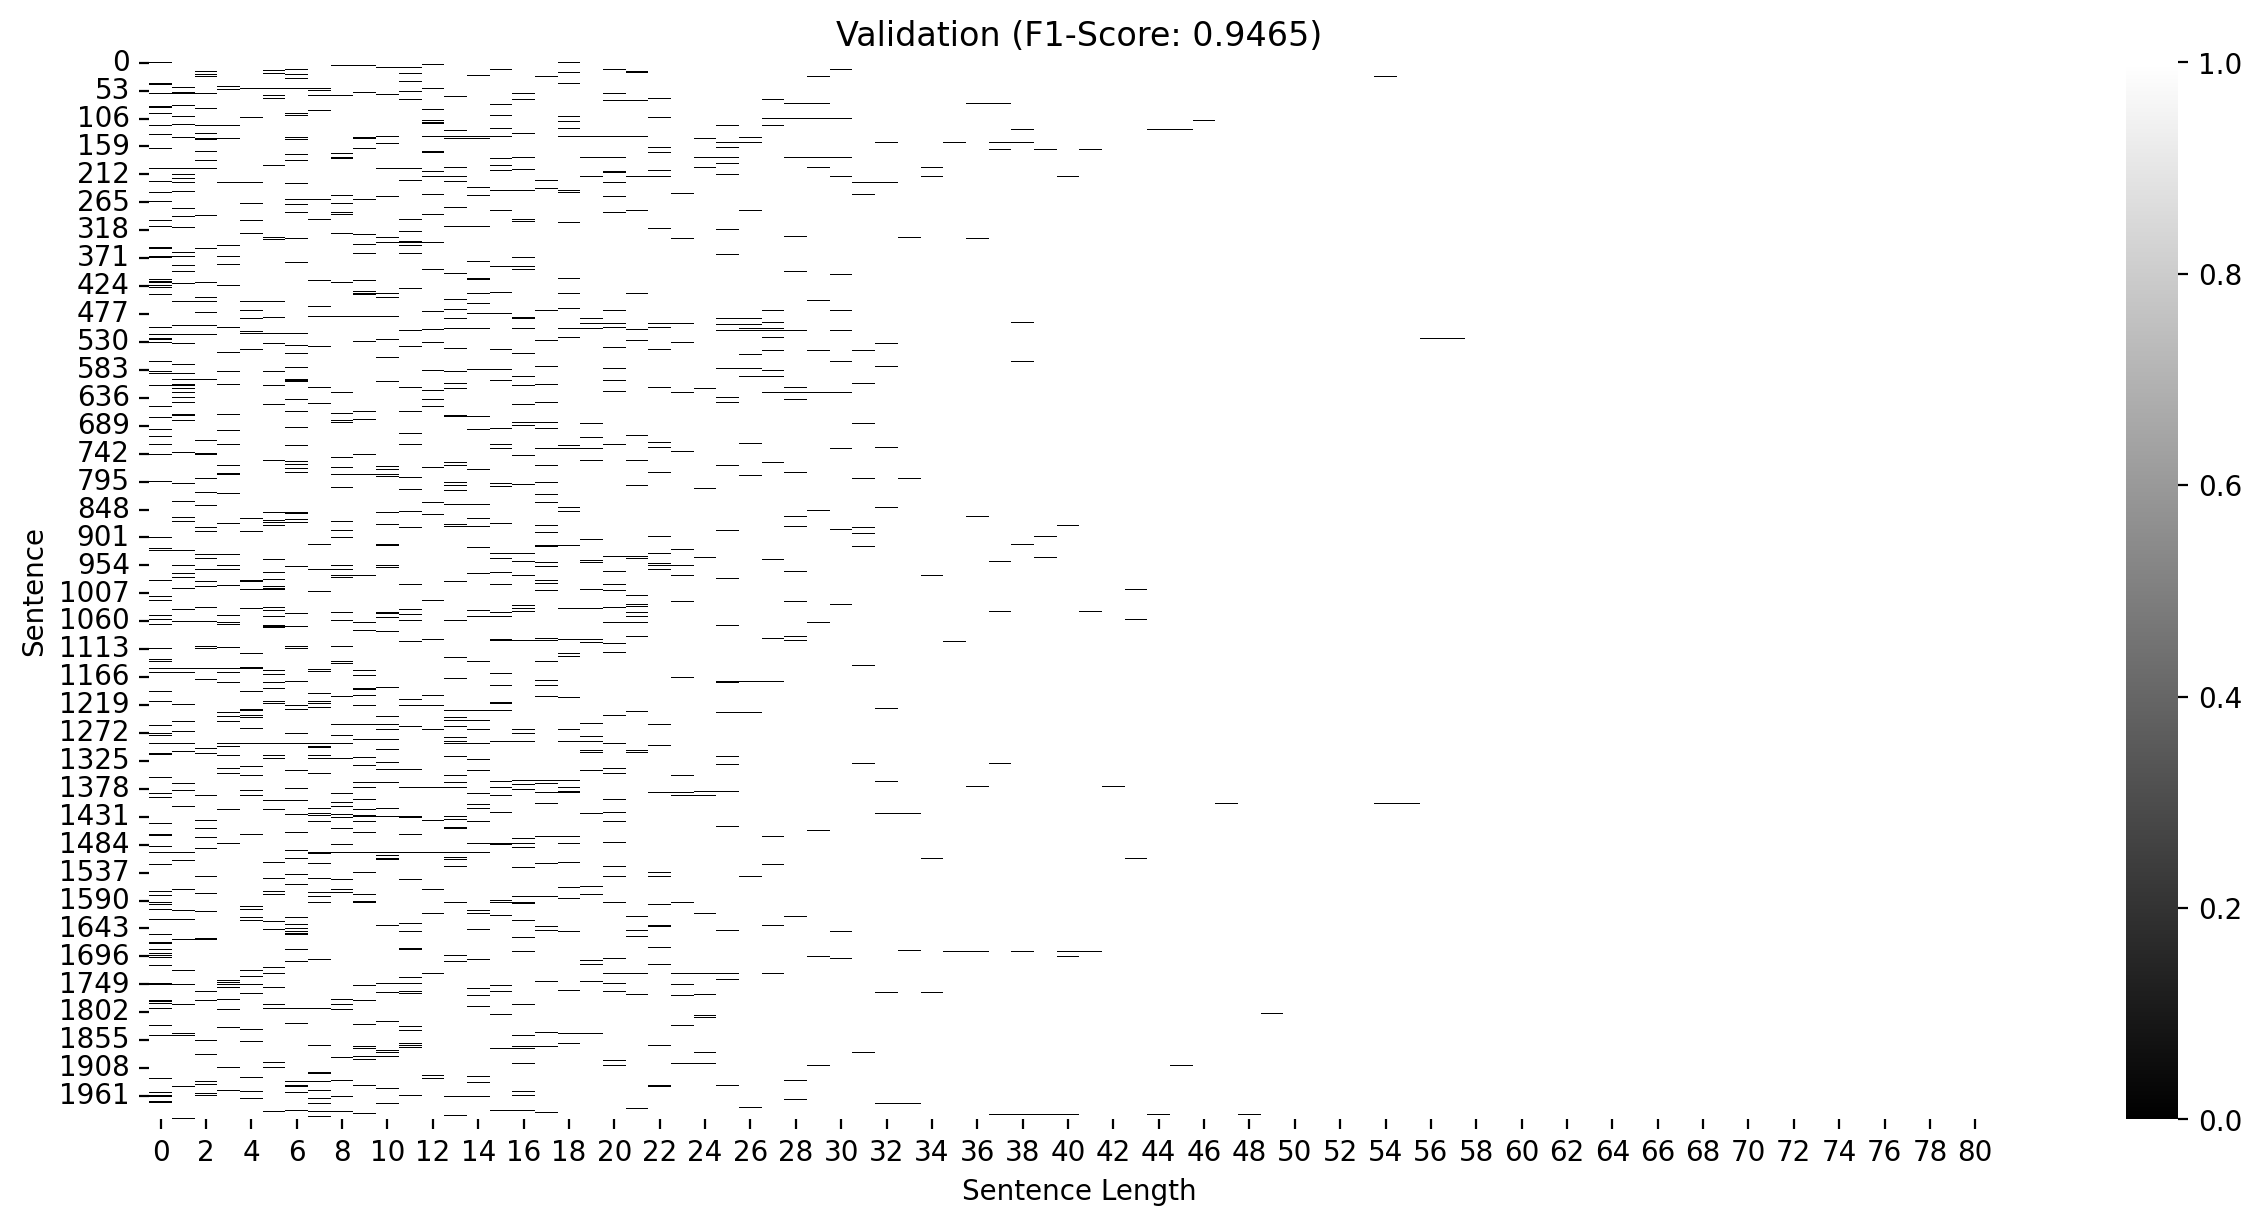

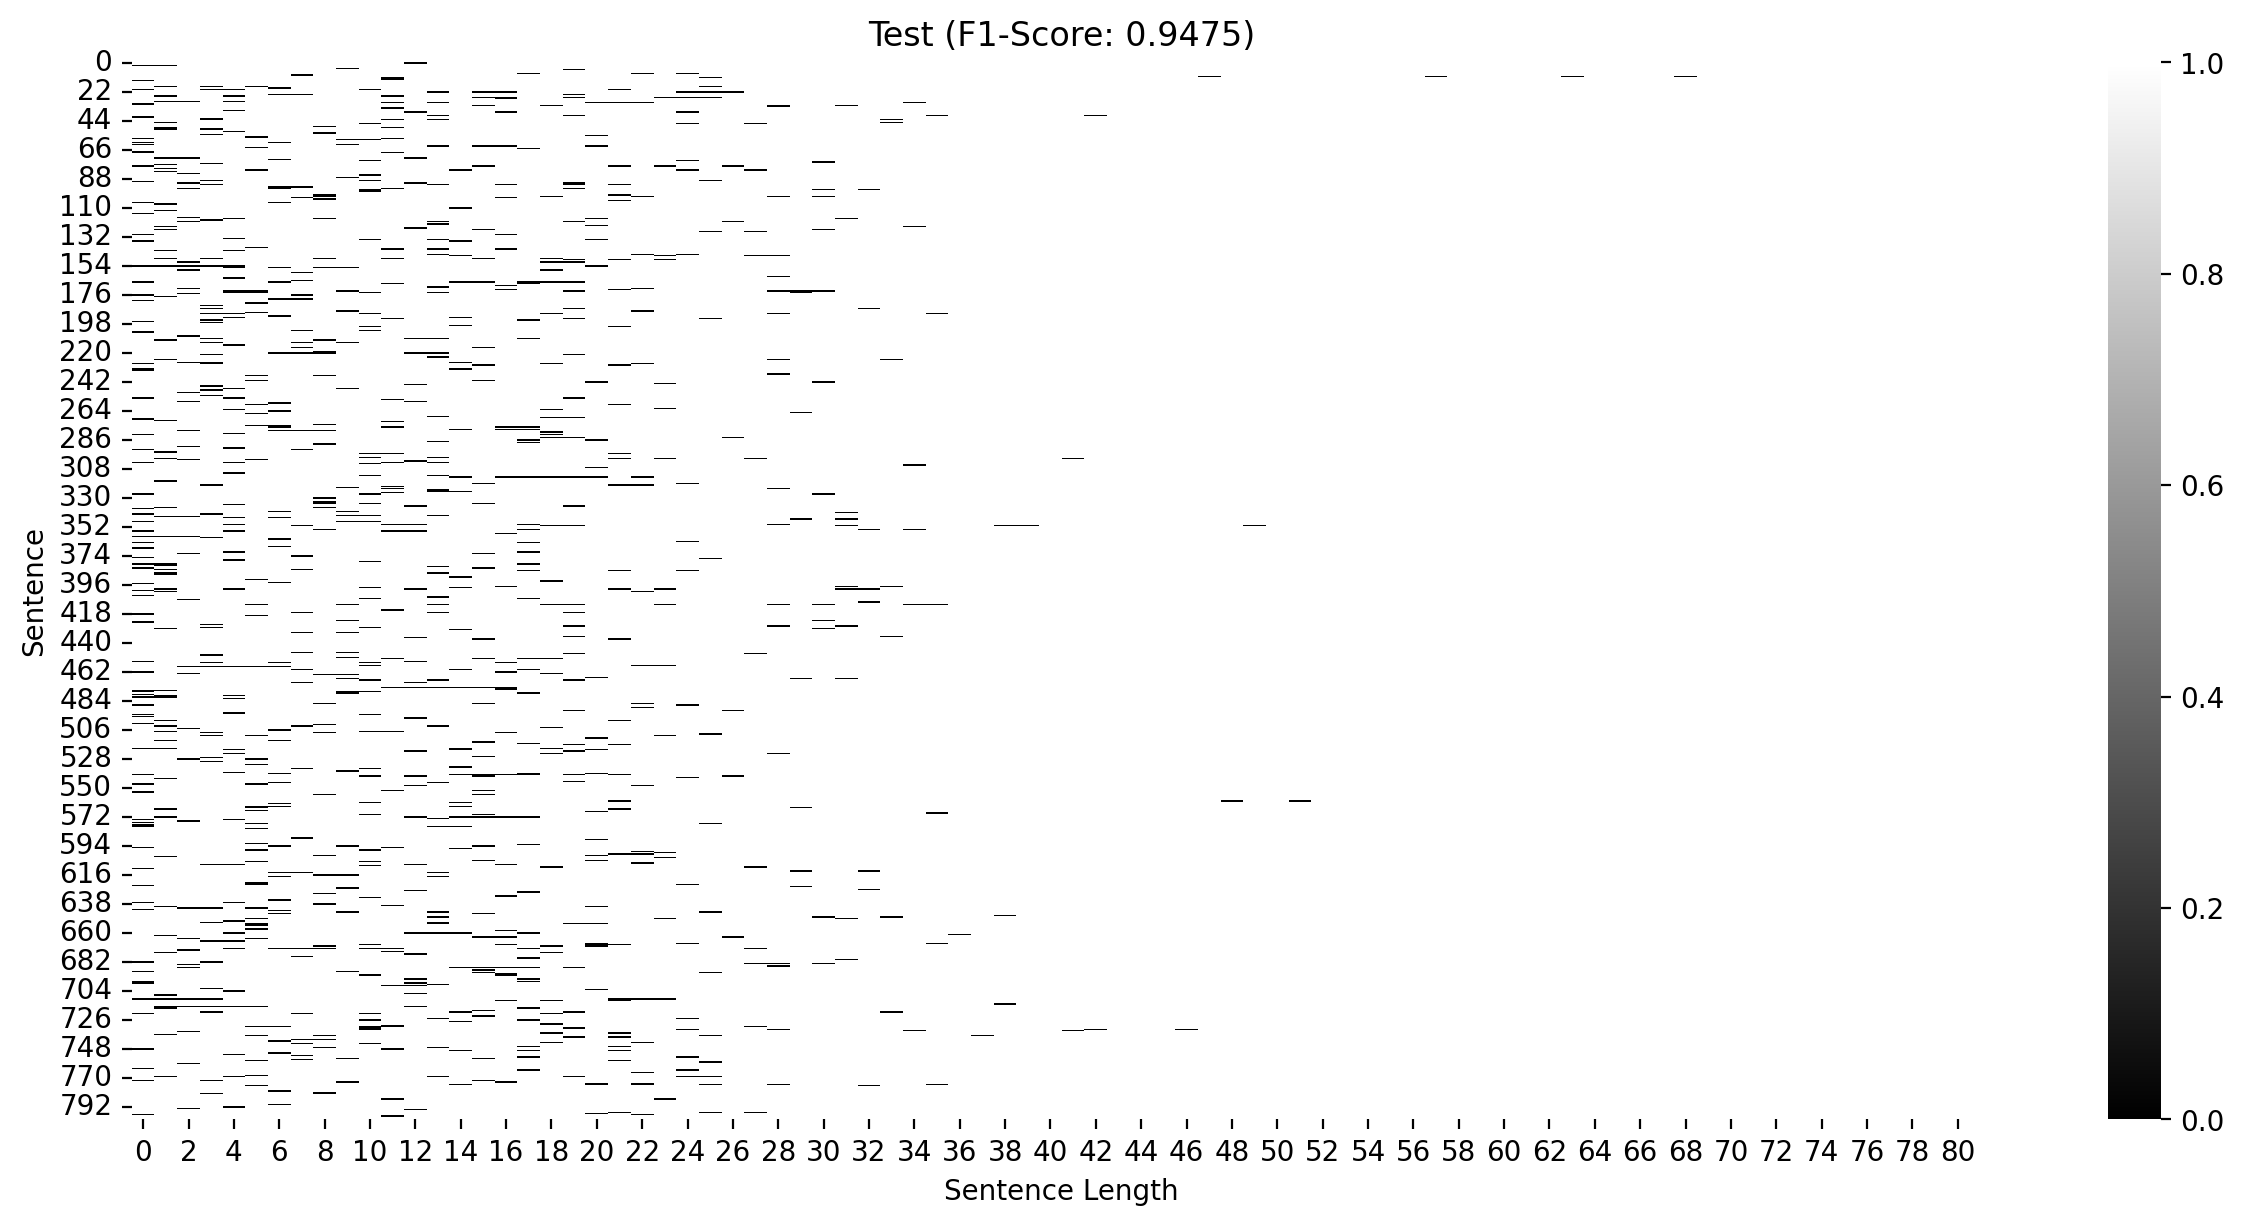

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


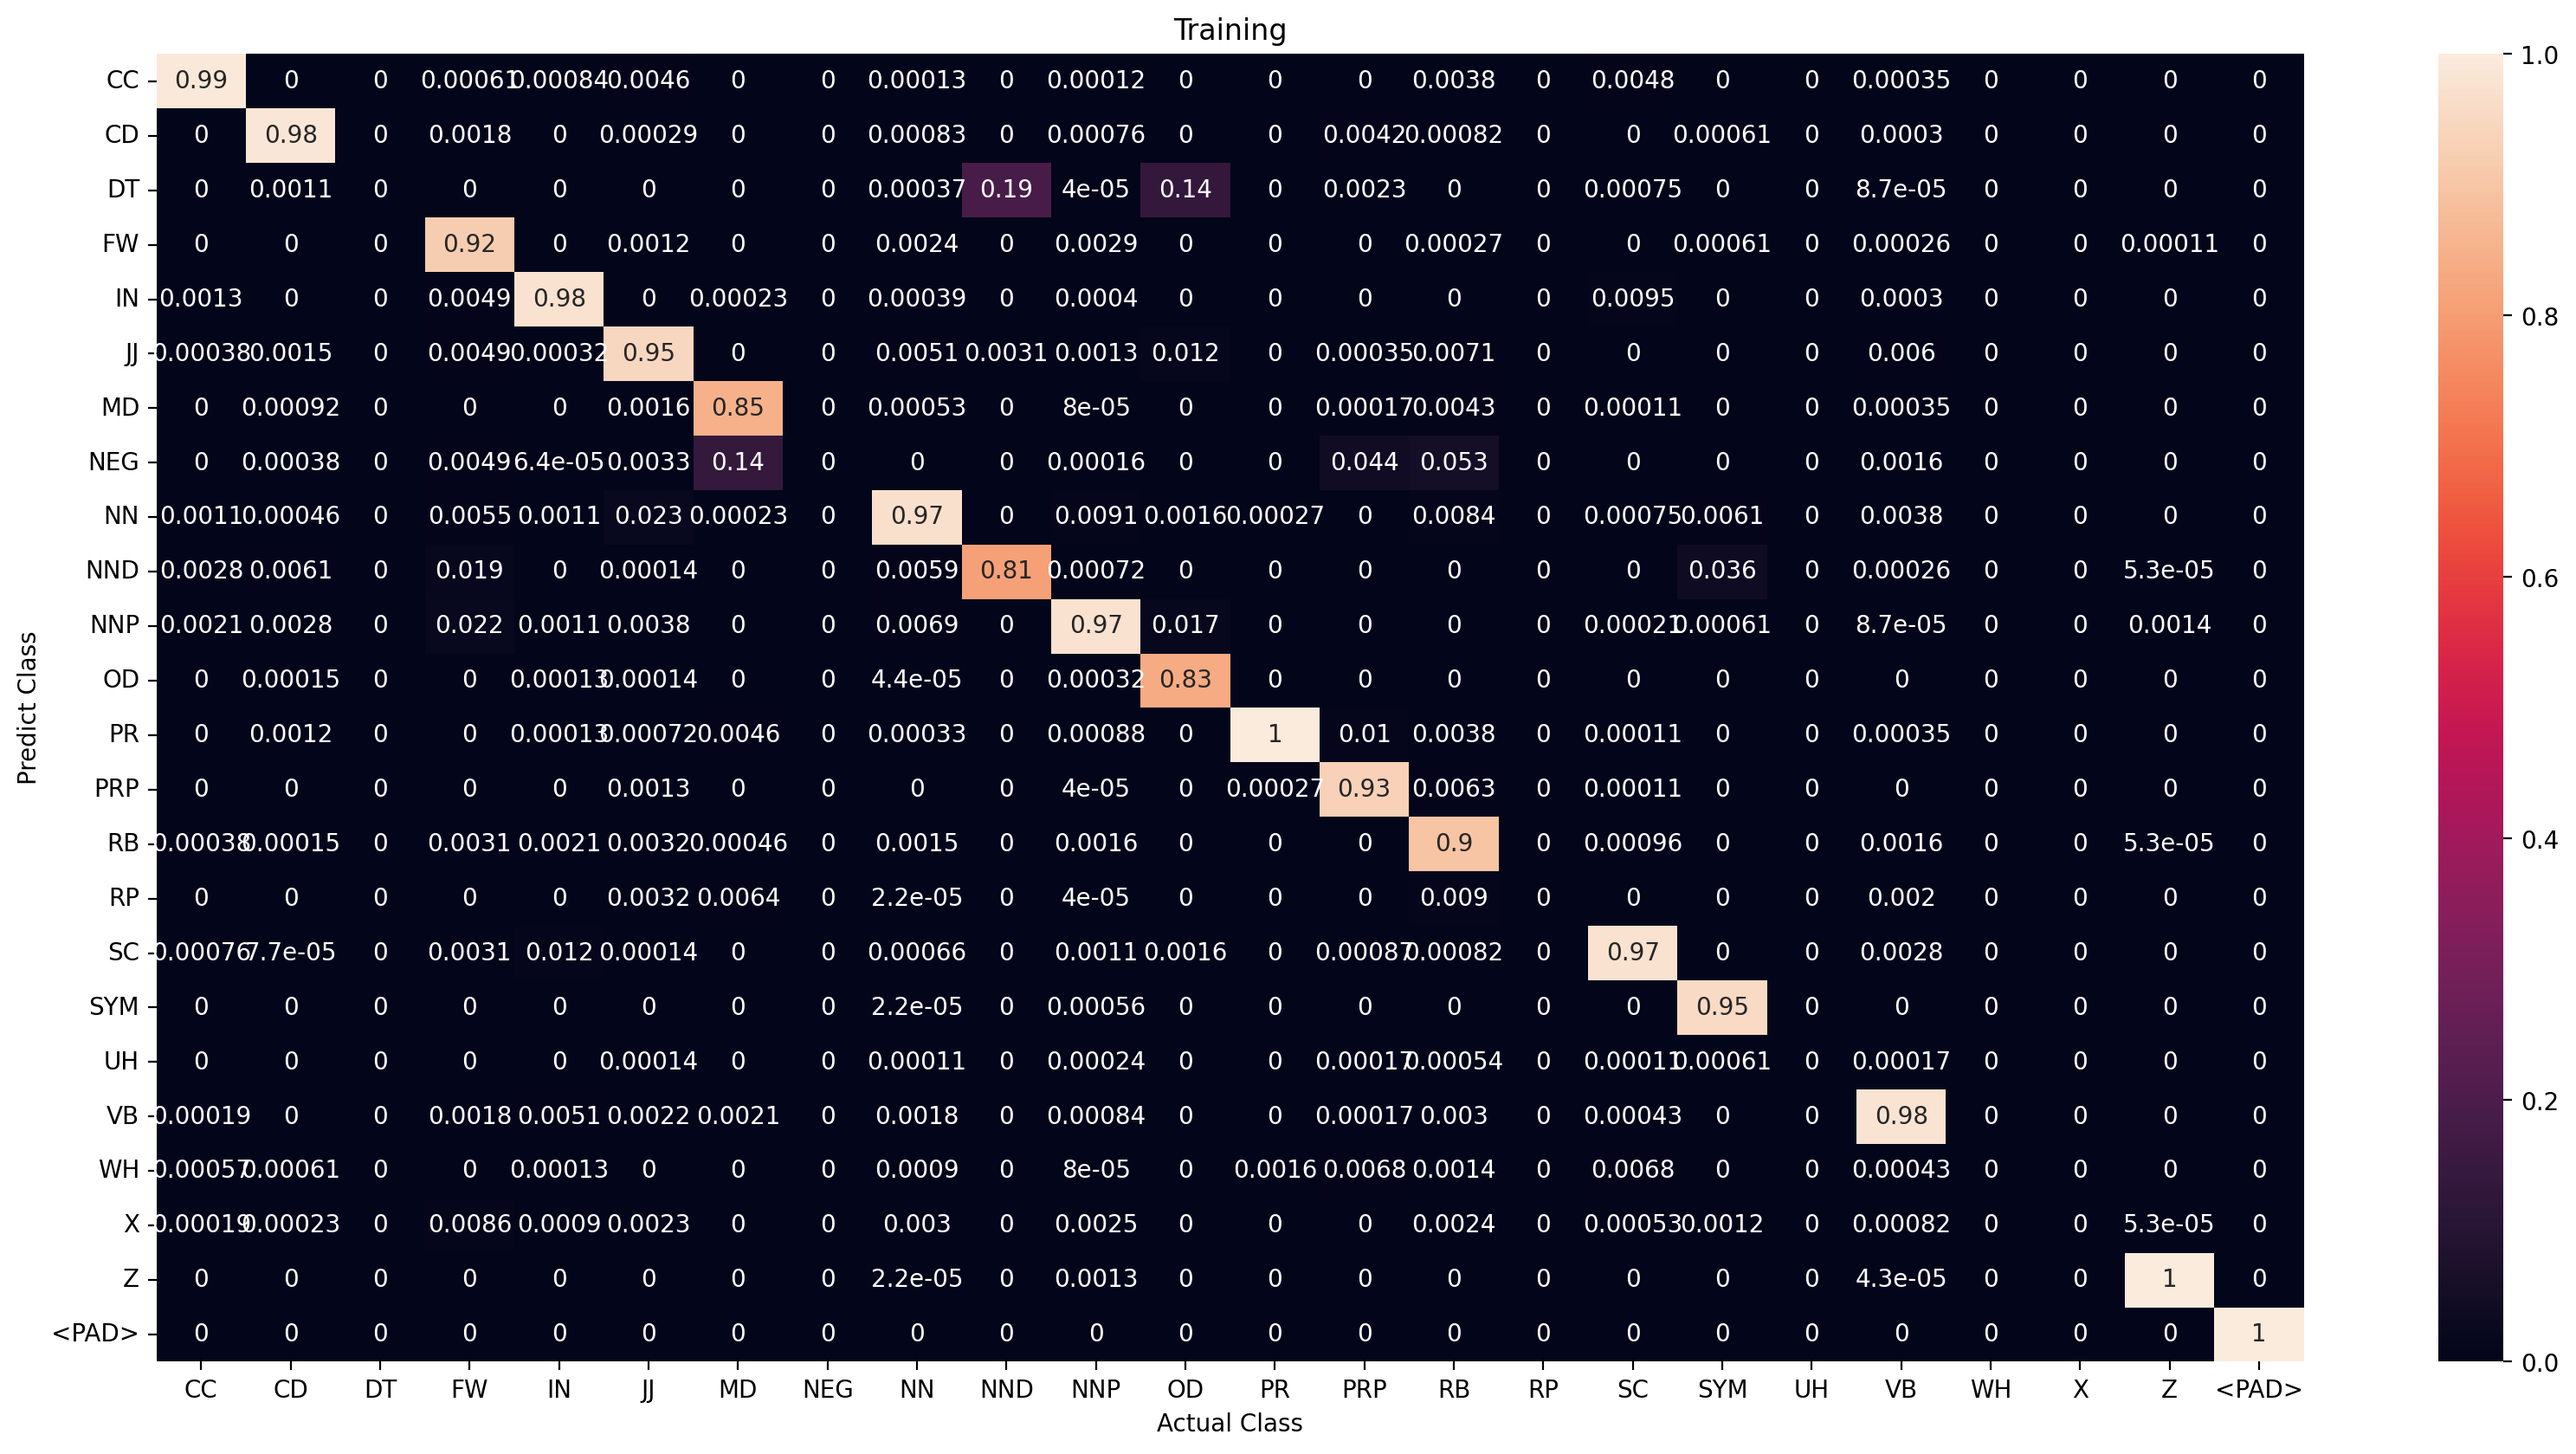

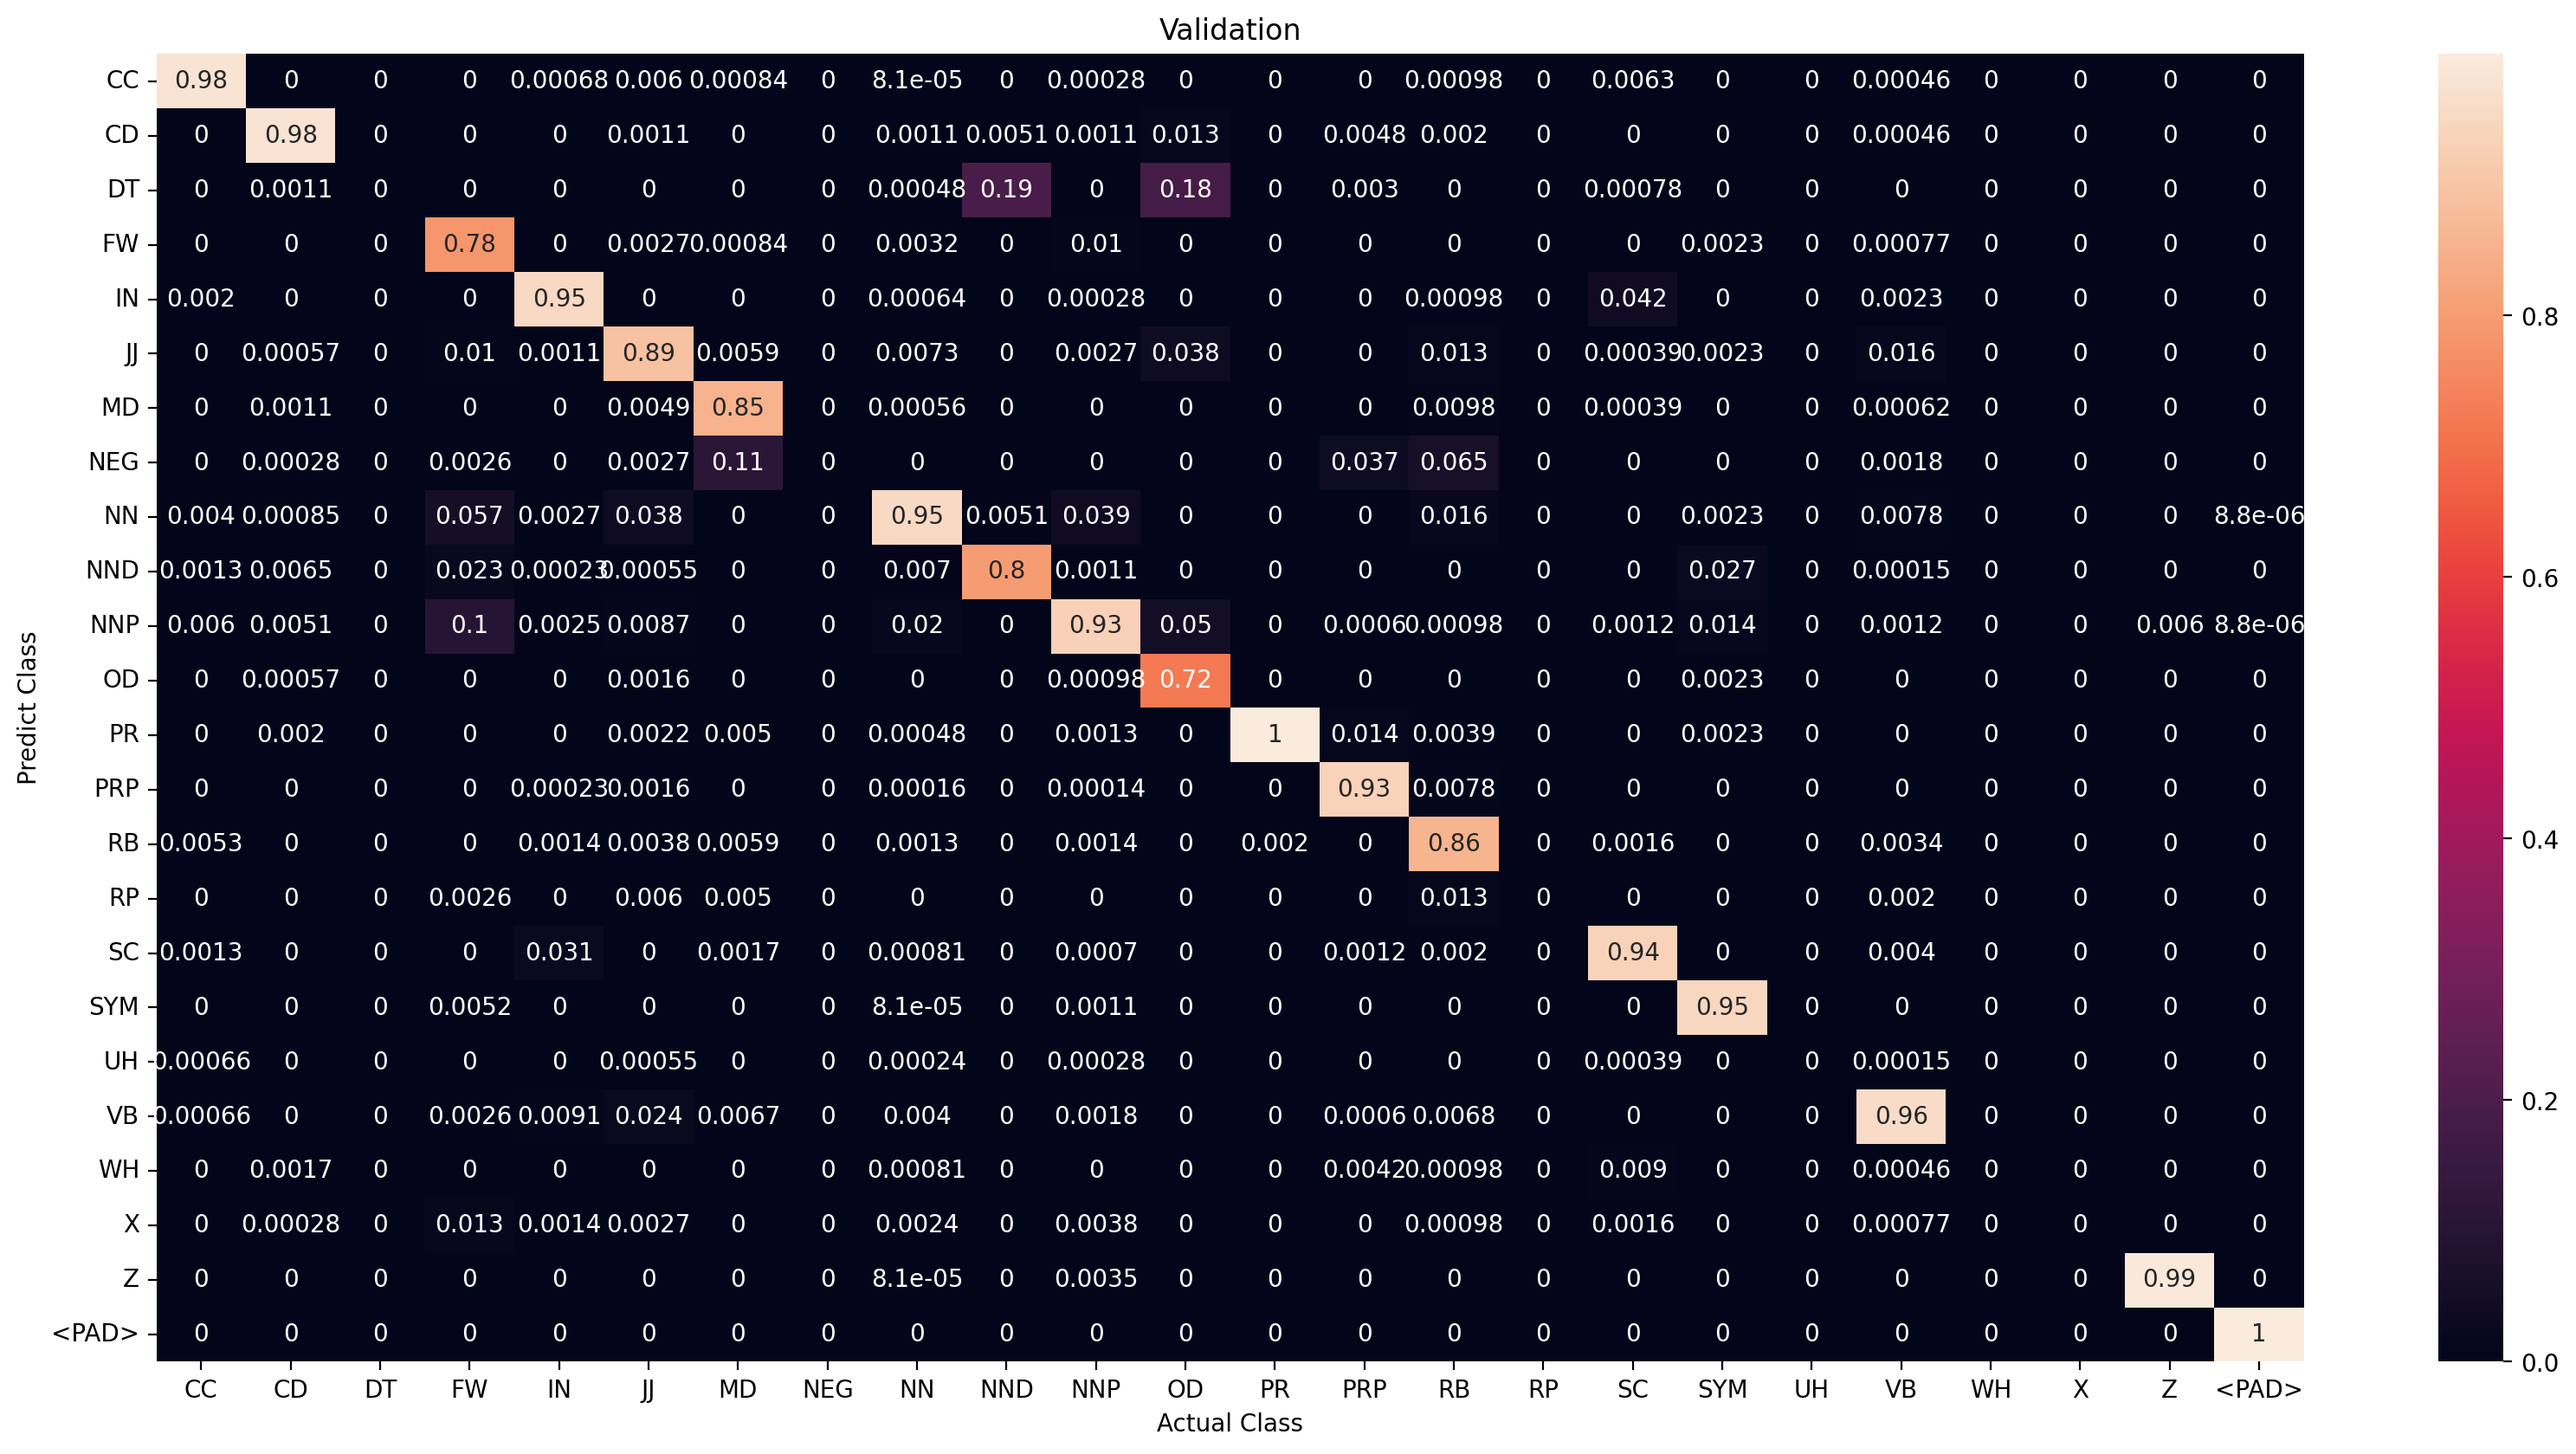

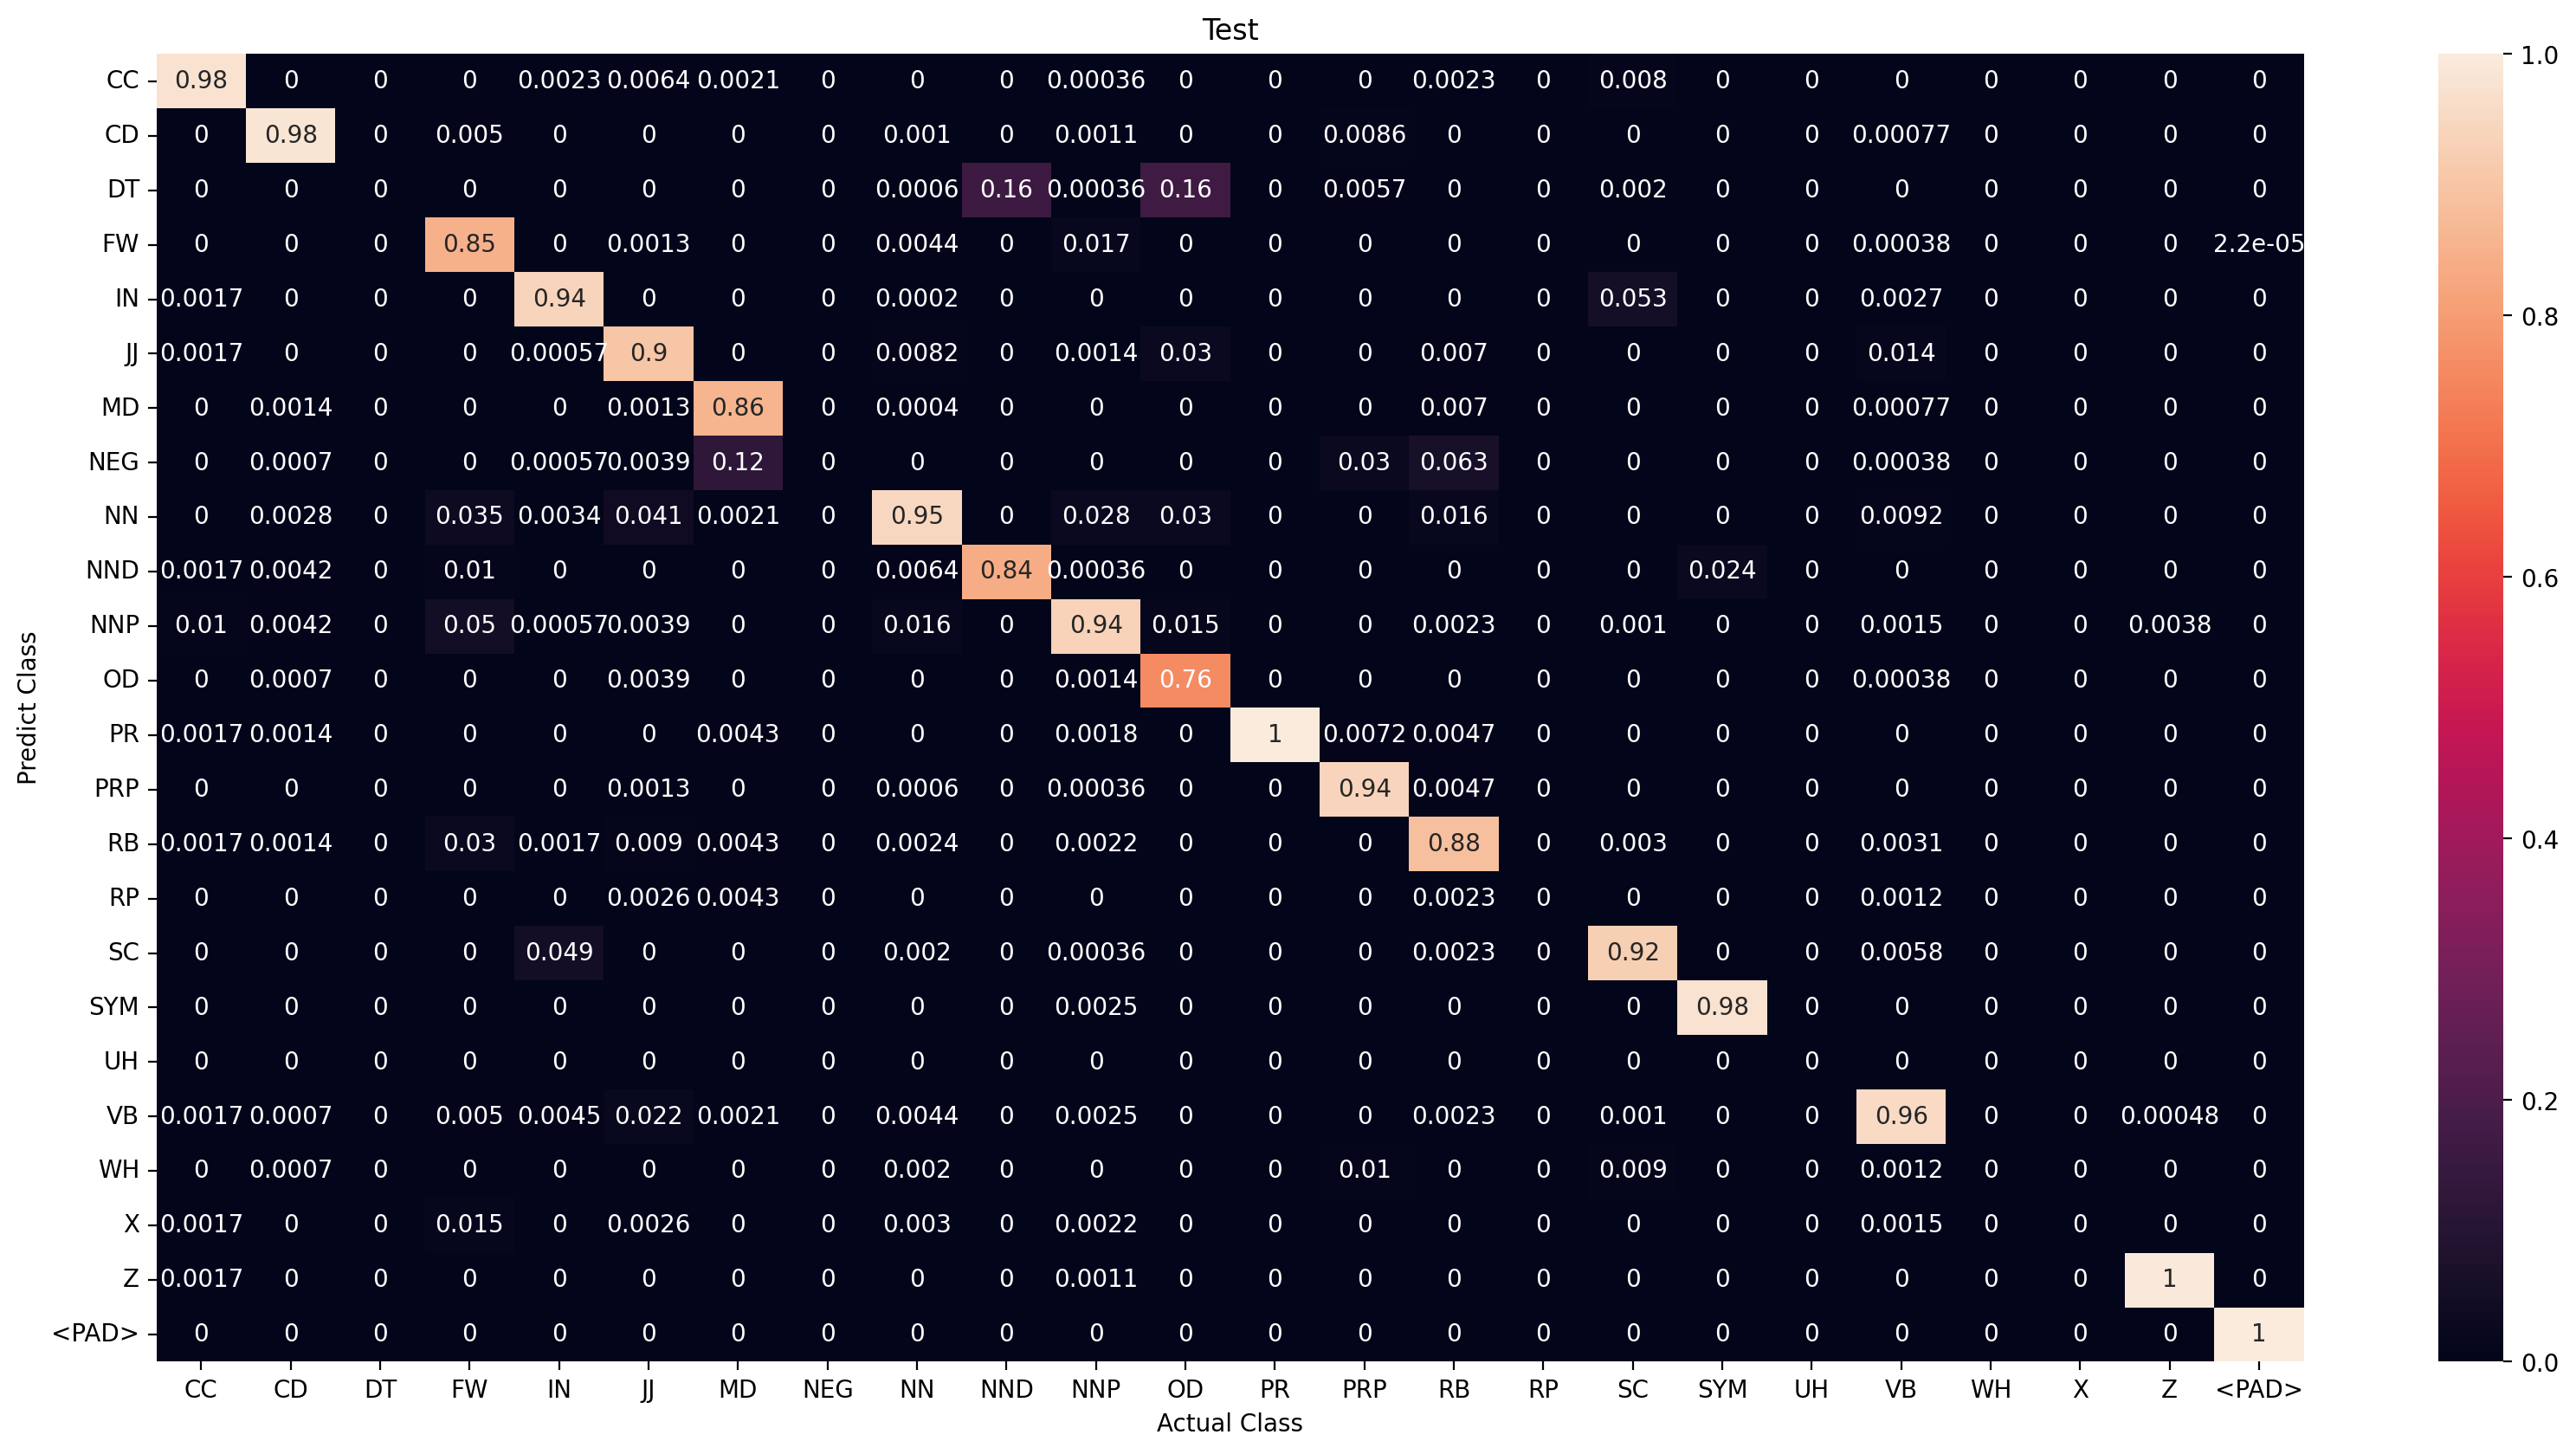

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5336   | CC    : 5214       | CC    : 122      |
| CD    : 12904  | CD    : 12807      | CD    : 97       |
| DT    : 263    | DT    : 0          | DT    : 263      |
| FW    : 1697   | FW    : 1498       | FW    : 199      |
| IN    : 15290  | IN    : 15150      | IN    : 140      |
| JJ    : 7049   | JJ    : 6575       | JJ    : 474      |
| MD    : 3783   | MD    : 3708       | MD    : 75       |
| NEG   : 1126   | NEG   : 0          | NEG   : 1126     |
| NN    : 44769  | NN    : 44206      | NN    : 563      |
| NND   : 998    | NND   : 519        | NND   : 479      |
| NNP   : 24884  | NNP   : 24400      | NNP   : 484      |
| OD    : 550    | OD    : 535        | OD    : 15       |
| PR    : 3878   | PR    : 3716       | PR    : 162      |
| PRP   : 5355   | PRP   : 5320       | PRP   : 35       |
| RB    : 3517   | RB    : 3295       | RB    : 222      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11934
Correct prediction          : 11083
Wrong prediction            : 851
Percentage correct oov pred : 92.86911345734875

Validation
Number OOV token            : 3261
Correct prediction          : 2925
Wrong prediction            : 336
Percentage correct oov pred : 89.69641214351427

Test
Number OOV token            : 1367
Correct prediction          : 1202
Wrong prediction            : 165
Percentage correct oov pred : 87.92977322604243



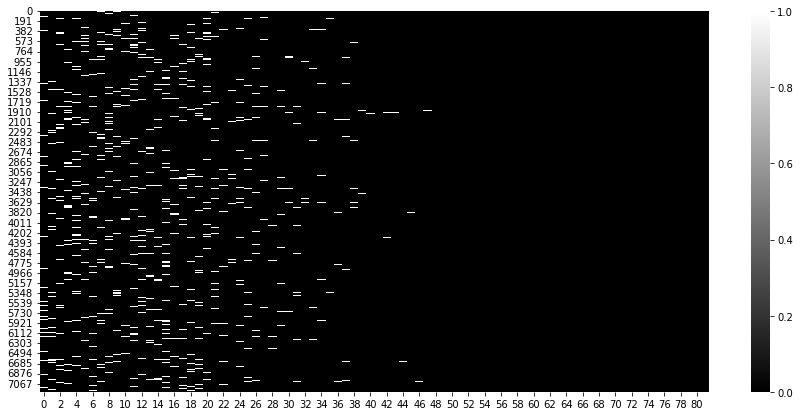

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

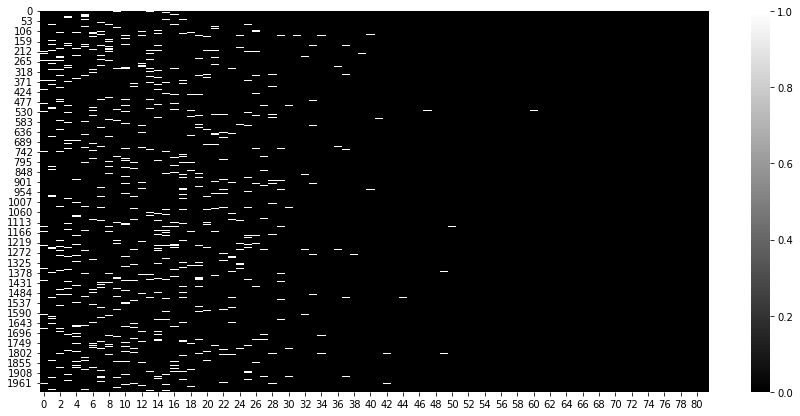

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

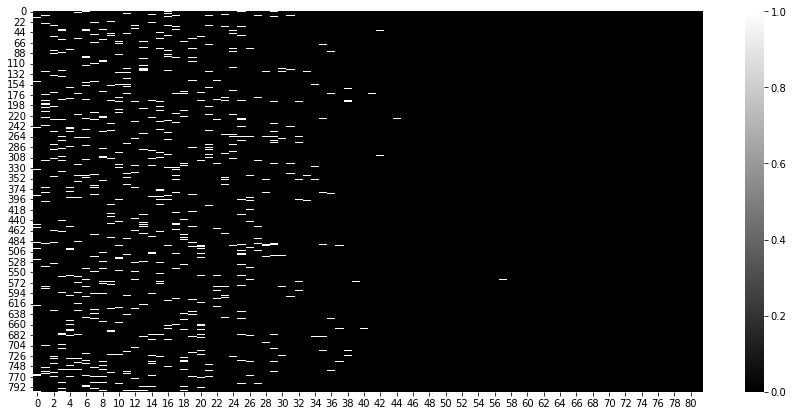

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);